In [2]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
from matplotlib import cm
from pylab import *
import matplotlib.lines as mlines

In [46]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [47]:
project = signac.get_project("ptb7-project")

In [61]:
state_dict = {'size': 'small', 'process': 'quench', "density": 0.8, "molecule": "PTB7_5mer_smiles"}

job_list = project.find_jobs(state_dict)
for job in job_list:
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    tspf = job.sp['n_steps'] / 100
    y = msd[-15:]
    x = np.arange(0, len(y), 1) * tspf
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    job.doc['msd_slope'] = slope
    job.doc['msd_slope_r2'] = r_value
    #print("slope of", job, "is:")
    print(slope)

1.4322858791341764e-05
9.967276123544667e-07
6.655800553118048e-07
2.2798804832529927e-06
9.325354690481024e-07
8.595164414486154e-06
8.816729571412948e-07
1.708901536611635e-05
1.5701210213547904e-05
1.1859801403146204e-05
1.6974561133166683e-05
1.9217912920642483e-05
4.637226745017212e-06
1.0569811406851617e-05
1.6087567961144018e-05
1.8810081134282484e-06
1.8917733299798845e-05


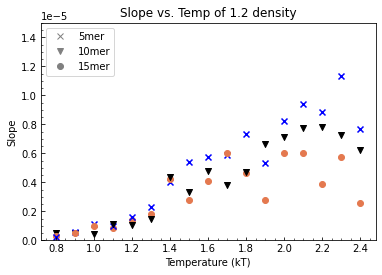

In [64]:
project = signac.get_project("ptb7-project")



state_dict = {'size': 'small', 'process': 'quench', 
              "density": 1.2}


job_list = project.find_jobs(state_dict)

fig = plt.figure()
ax = plt.subplot(111)
state_dict['kT_reduced.$lt'] = 2.5
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

#mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
#col = np.arange(17)
   
for temp,job in enumerate(job_list):
    
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    mark = "x"
    #print(job.sp)
    if job.sp["molecule"] == 'PTB7_5mer_smiles':
        mark = "x"
        col = ['blue']
    if job.sp["molecule"] == 'PTB7_10mer_smiles':
        mark = "v"
        col = ['black']
    if job.sp["molecule"] == 'PTB7_15mer_smiles':
        mark = "o"
        col = ['#e4794f']
    plt.ylim(0, 0.0001)
    plt.scatter(x2,y2, label=temp, marker=mark, c =col)#, marker=mpl.markers)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in')
    plt.ylim(0, 0.000015)
plt.title('Slope vs. Temp of 1.2 density')
plt.xlabel('Temperature (kT)')
plt.ylabel('Slope')

mer_5 = mlines.Line2D([], [], color='grey', marker='x', linestyle='None',
                      label='5mer')
mer_10 = mlines.Line2D([], [], color='grey', marker='v', linestyle='None',
                       label='10mer')
mer_15 = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                       label='15mer')

plt.legend(handles=[mer_5, mer_10, mer_15], loc="upper left")

plt.show()


In [40]:
s_d = [("({'size': 'small', 'process': 'quench', 'density': 1.0, 'molecule':'PTB7_5mer_smiles'})"),
       ("({'size': 'small', 'process': 'quench', 'density': 1.0, 'molecule':'PTB7_10mer_smiles'})"),
       ("({'size': 'small', 'process': 'quench', 'density': 1.0, 'molecule':'PTB7_15mer_smiles'})")]



for molecule,idx in enumerate(state_dict):
    
    state_dict = s_d[idx]

    job_list = project.find_jobs(state_dict)
    fig = plt.figure()
    #ax = plt.subplot(111)
    state_dict['kT_reduced.$lt'] = 2.5
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))

    mpl.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

    for temp,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        msd = msd_from_gsd(job.fn('trajectory.gsd'))
        slope = job.doc['msd_slope']
        x2=job.sp["kT_reduced"]
        y2=slope
        plt.ylim(0, 0.00014)
        plt.scatter(x2,y2, label=temp)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

#    if job.sp['molecule'] == "PTB7_5mer_smiles":
#        mol = "5mer"
#    if job.sp['molecule'] == "PTB7_10mer_smiles":
#        mol = "10mer"
#    if job.sp['molecule'] == "PTB7_15mer_smiles":
#        mol = "15mer"
#    plt.title("Slope vs. Temp of PTB7 %s at %s density" % (mol, job.sp['density']), fontsize=11.75 )
    #plt.xlabel("Temperature(kT)")
    #plt.ylabel("Slope")
    #plt.show()

TypeError: list indices must be integers or slices, not str

In [8]:
#counting # of jobs for scatter plot 
#for index,job in enumerate(job_list):    
#    x2=job.sp["kT_reduced"]
#    y2=slope
#    print(index, x2, y2)


#to get hex from colormap
#from pylab import *
#cmap = cm.get_cmap('seismic', 17)    # PiYG
#for i in range(cmap.N):
#    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#    print(matplotlib.colors.rgb2hex(rgb))